In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import date, timedelta

In [2]:
end_date = date.today().strftime('%Y-%m-%d')
start_date = (date.today() - timedelta(days=365)).strftime('%Y-%m-%d')

tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'ACN', 'NVDA', 'LLY', 'PFE', 'BRK-B', 'V', 'META']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

data = data.reset_index()

data_melted = data.melt(id_vars=['Date'], var_name=['Attribute','Ticker'])

data_pivoted = data_melted.pivot_table(index=['Date','Ticker'], columns='Attribute', values='value', aggfunc = 'first')

df = data_pivoted.reset_index()

df.head()



Attribute,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2023-08-07,AAPL,177.905197,178.850006,183.130005,177.350006,182.130005,97576100.0
1,2023-08-07,ACN,310.848724,315.869995,316.130005,312.049988,314.089996,1530600.0
2,2023-08-07,AMZN,142.220001,142.220001,142.539993,138.949997,140.990005,71213100.0
3,2023-08-07,BRK-B,362.579987,362.579987,364.630005,355.149994,355.730011,5379900.0
4,2023-08-07,GOOGL,131.379211,131.529999,131.610001,129.020004,129.160004,22746300.0


In [3]:
df['Ticker'].value_counts()

,count
Ticker,
AAPL,250
ACN,250
AMZN,250
BRK-B,250
GOOGL,250
LLY,250
META,250
MSFT,250
NVDA,250


<function matplotlib.pyplot.show(close=None, block=None)>

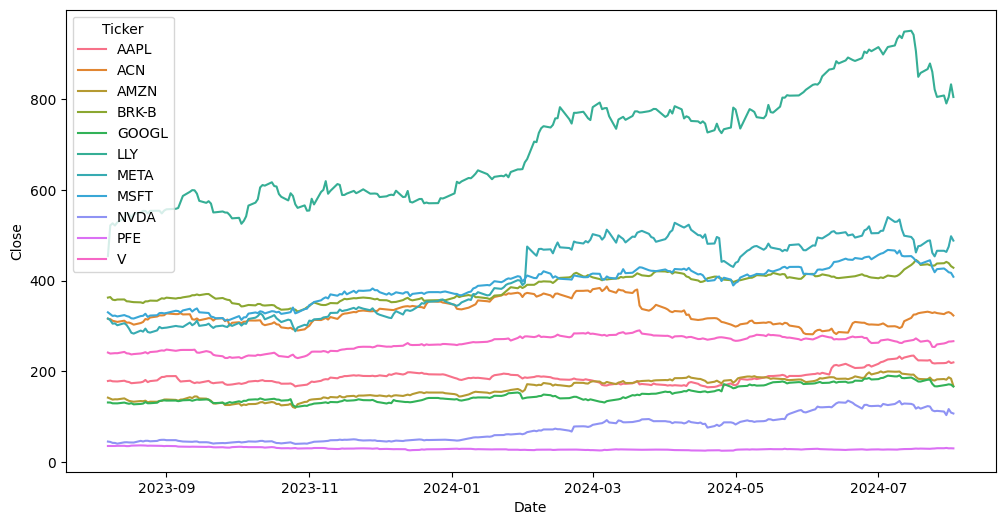

In [4]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='Close', hue='Ticker')
plt.show

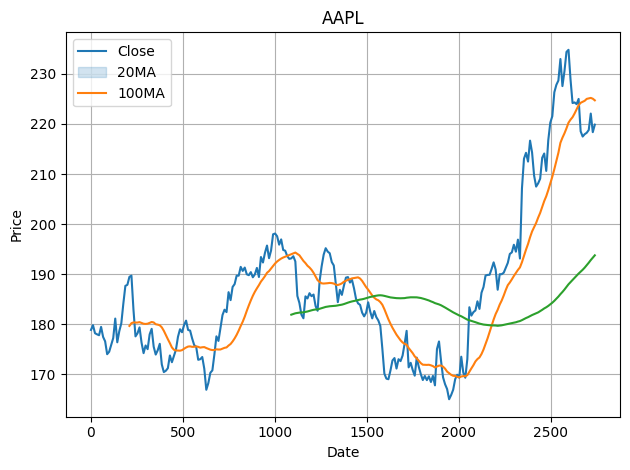

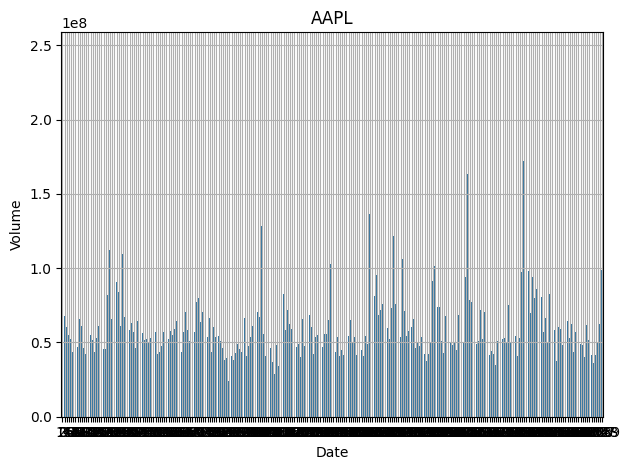

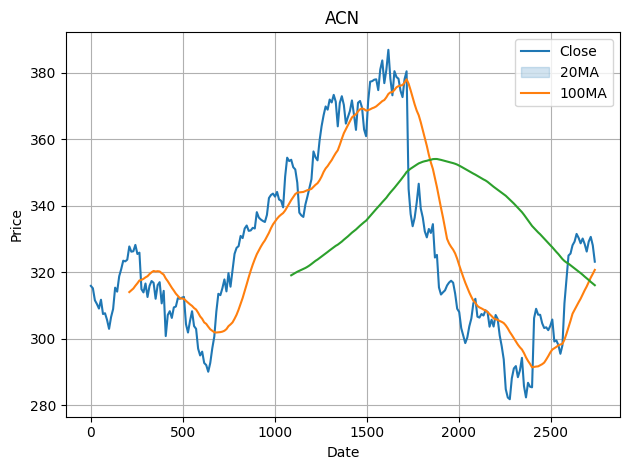

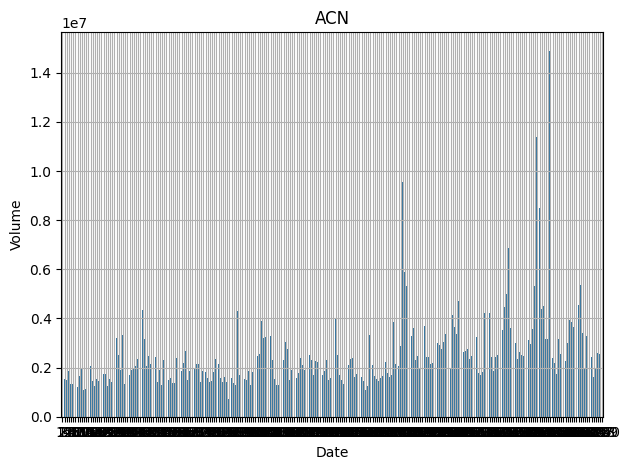

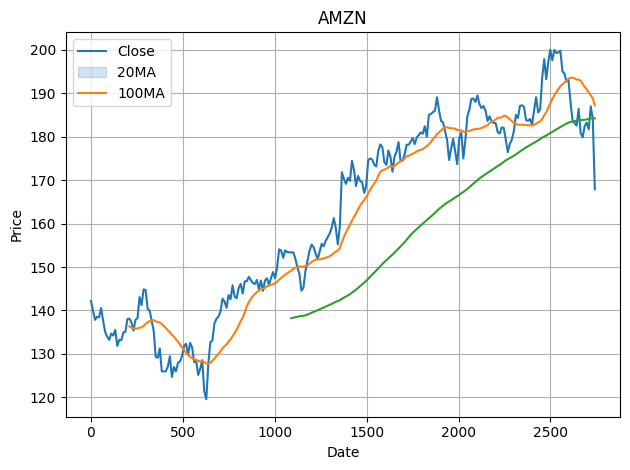

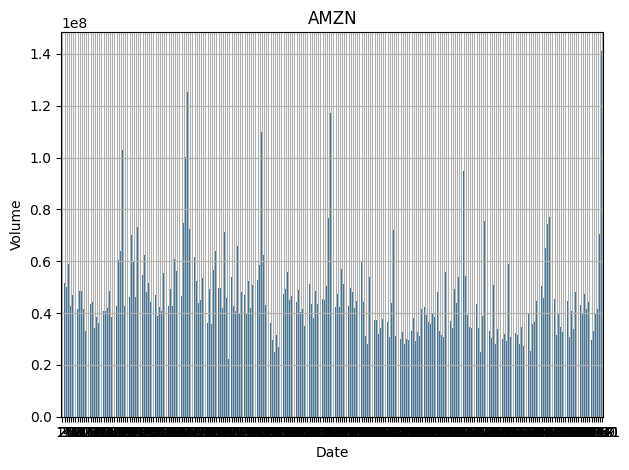

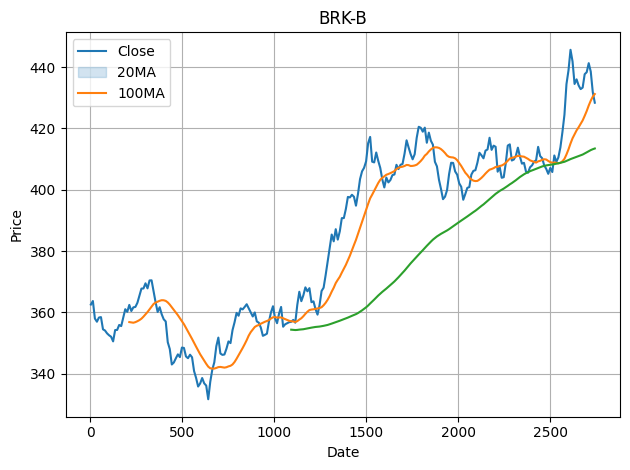

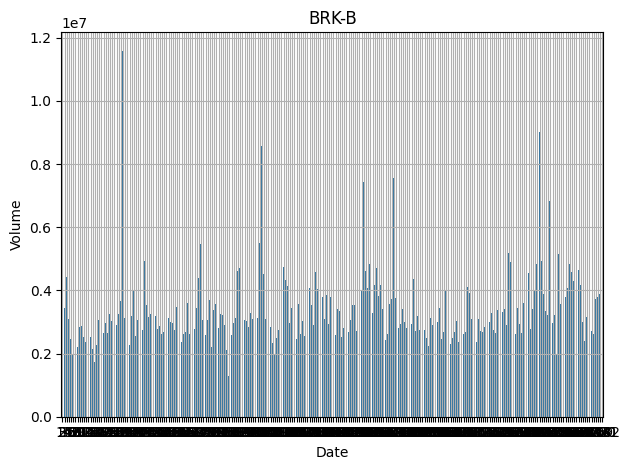

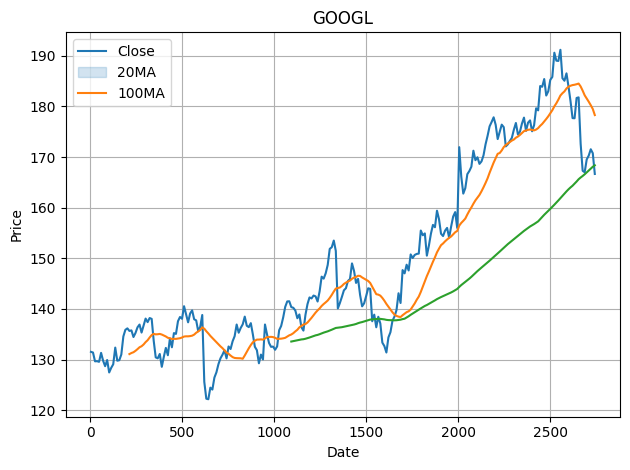

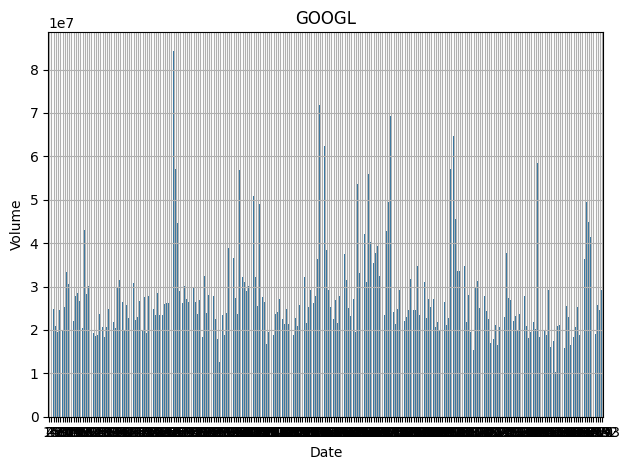

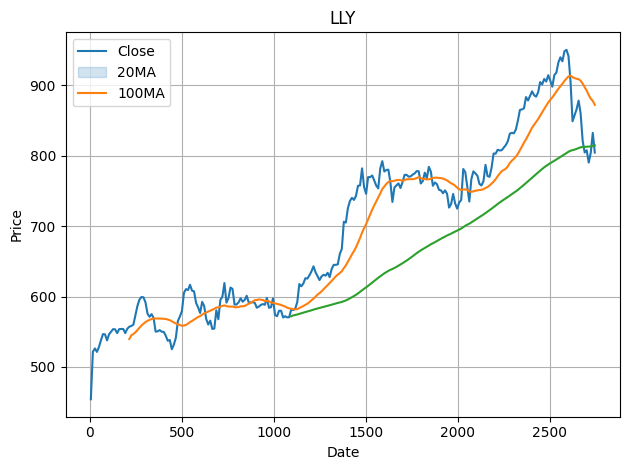

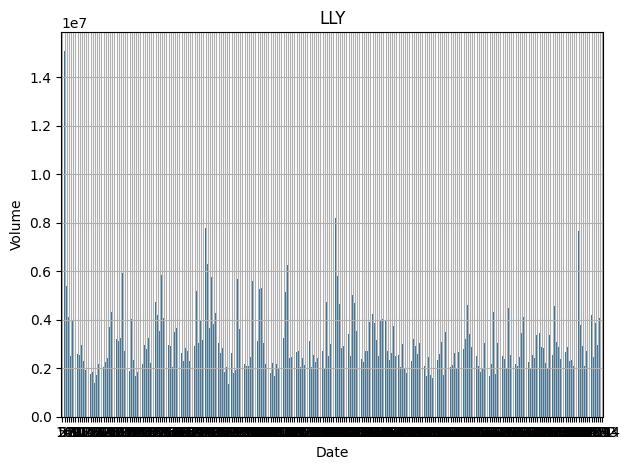

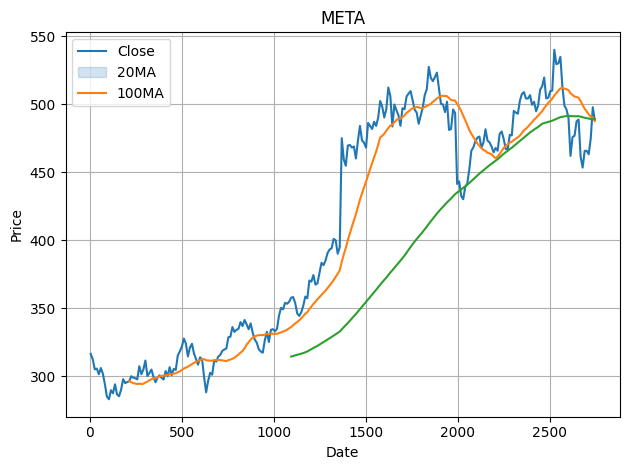

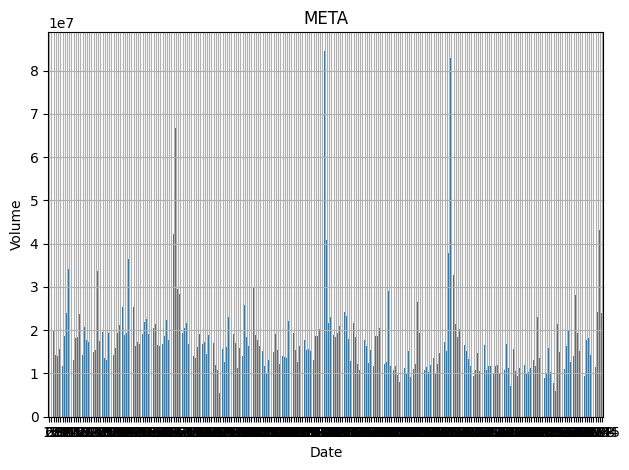

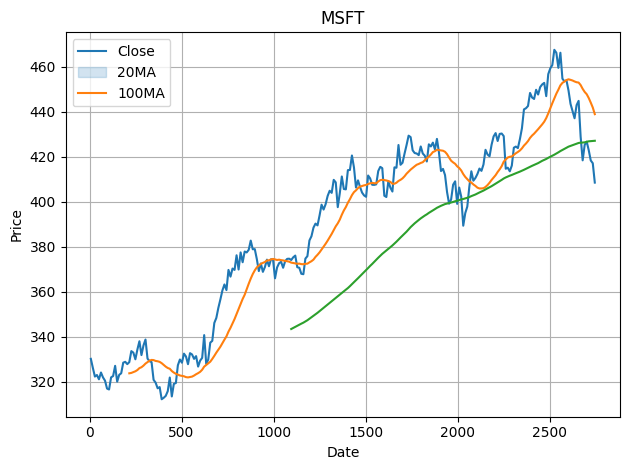

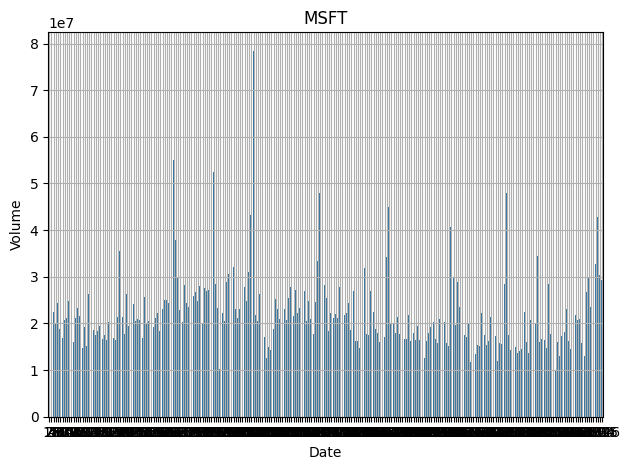

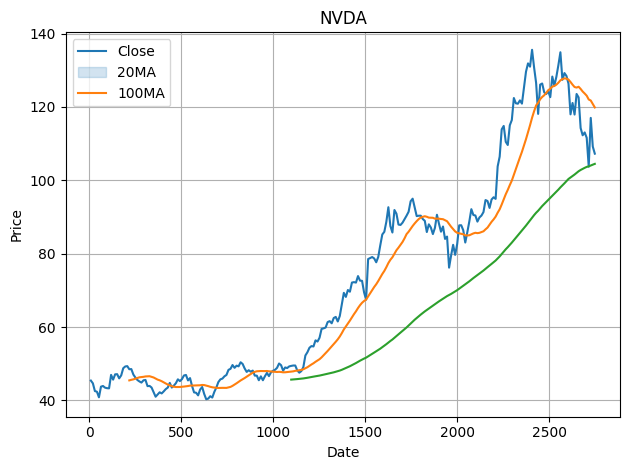

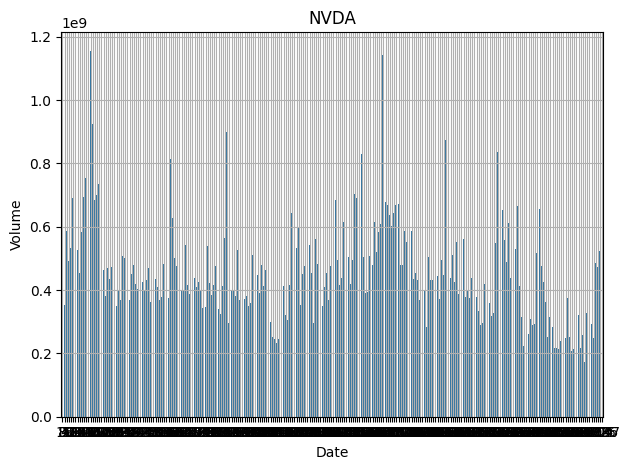

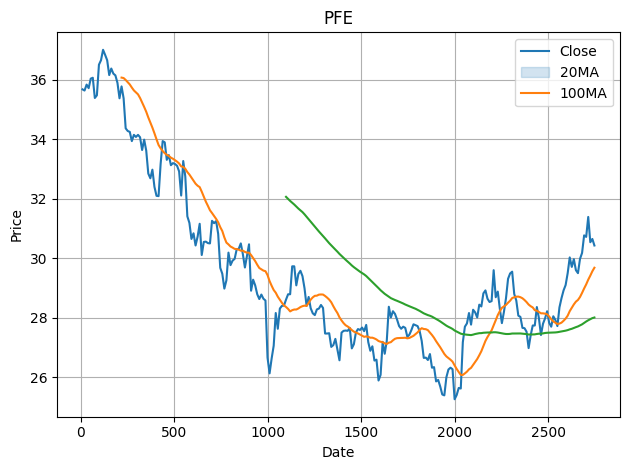

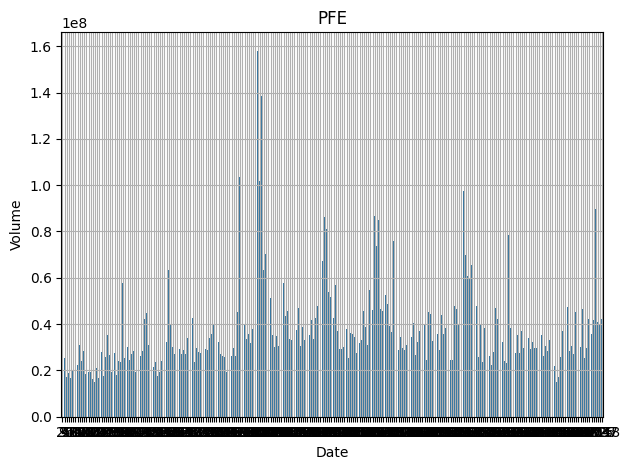

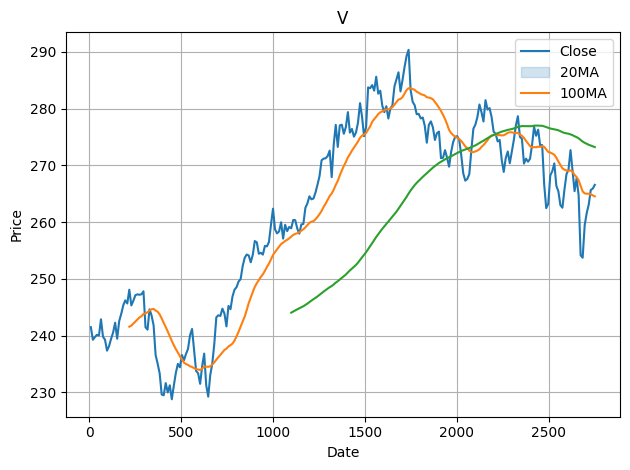

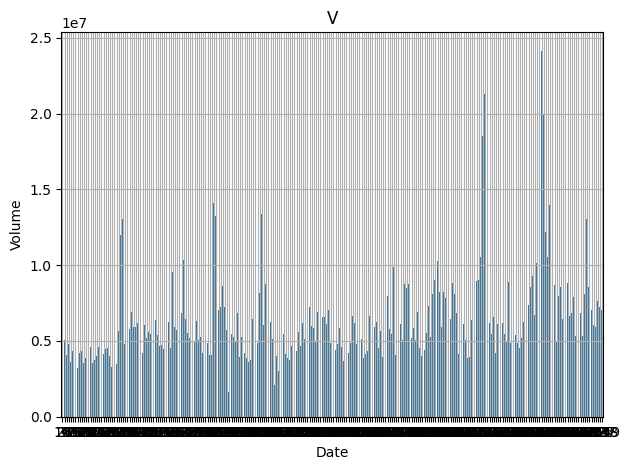

In [5]:

tickers = df['Ticker'].unique()

for ticker in tickers:
  ticker_df = df[df['Ticker'] == ticker].copy()
  ticker_df['20MA'] = ticker_df['Close'].rolling(window=20).mean()
  ticker_df['100MA'] = ticker_df['Close'].rolling(window=100).mean()

  sns.lineplot(data=ticker_df, x=ticker_df.index, y='Close')
  sns.lineplot(data=ticker_df, x=ticker_df.index, y='20MA')
  sns.lineplot(data=ticker_df, x=ticker_df.index, y='100MA')
  plt.title(ticker)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend(['Close', '20MA', '100MA'])
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  sns.barplot(data=ticker_df, x=ticker_df.index, y='Volume')
  plt.title(ticker)
  plt.xlabel('Date')
  plt.ylabel('Volume')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

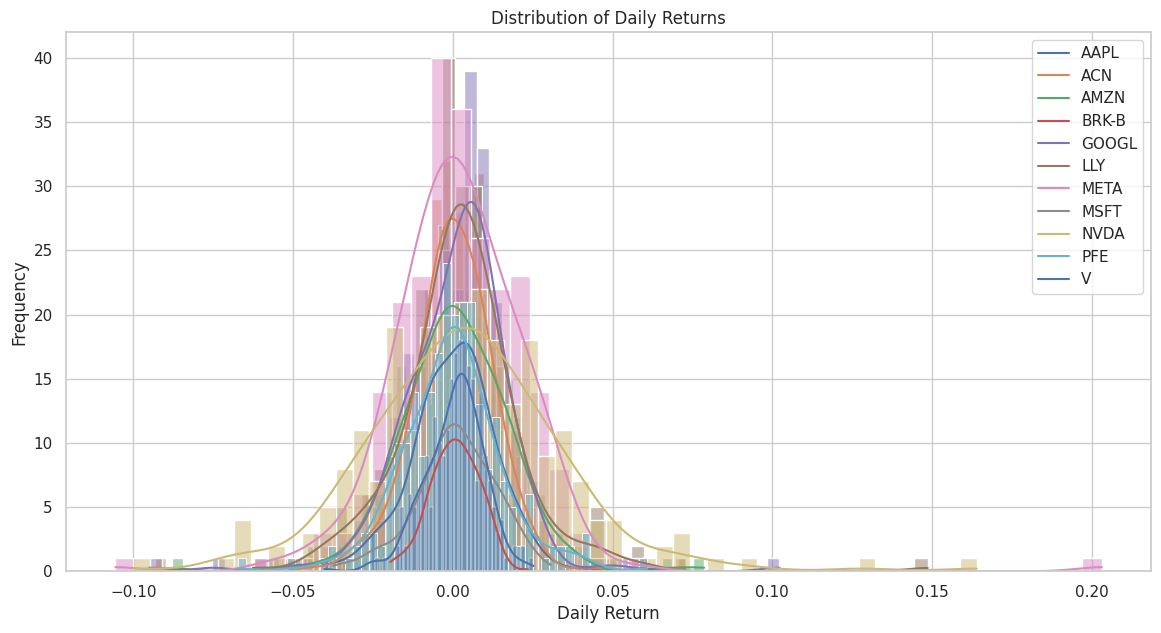

In [14]:
df['daily_return'] = df.groupby('Ticker')['Close'].pct_change()

plt.figure(figsize=(14,7))
sns.set(style='whitegrid')

for ticker in tickers:
  ticker_df = df[df['Ticker'] == ticker]
  sns.histplot(data=ticker_df, x='daily_return', kde=True, bins = 50, alpha=0.5)

plt.title("Distribution of Daily Returns")
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend(tickers)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

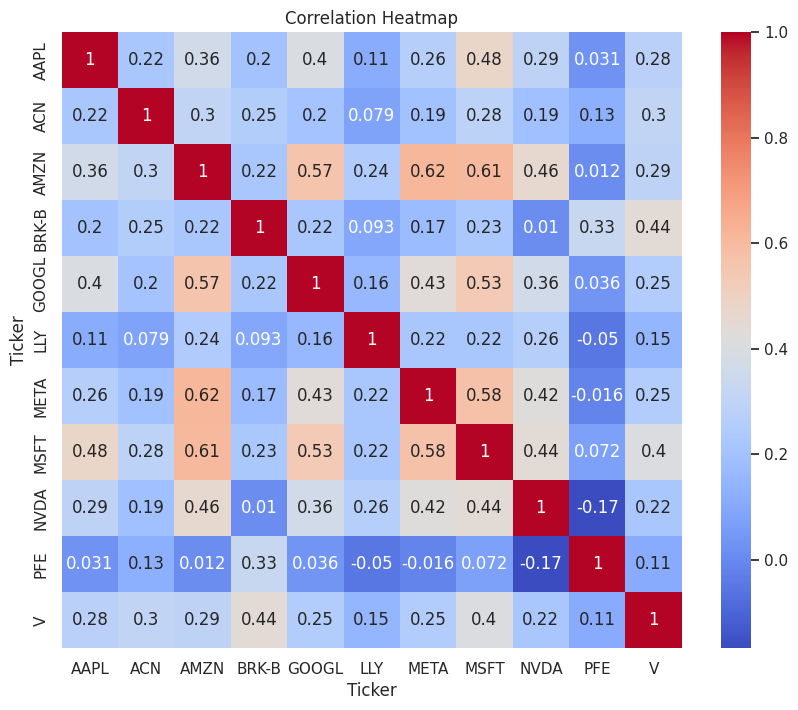

In [7]:
returns = df.pivot_table(index='Date', columns='Ticker', values='daily_return')
corr = returns.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show

In [8]:
exp_returns = returns.mean()*252
volatility = returns.std()*np.sqrt(252)

In [9]:
stock_performance = pd.DataFrame({
    'exp_returns': exp_returns,
    'volatility':volatility
})

stock_performance

,exp_returns,volatility
Ticker,,
AAPL,0.233449,0.222153
ACN,0.048325,0.224339
AMZN,0.207158,0.280035
BRK-B,0.176138,0.121509
GOOGL,0.277568,0.275189
LLY,0.627461,0.313696
META,0.504775,0.369591
MSFT,0.235139,0.197296
NVDA,0.990868,0.493680


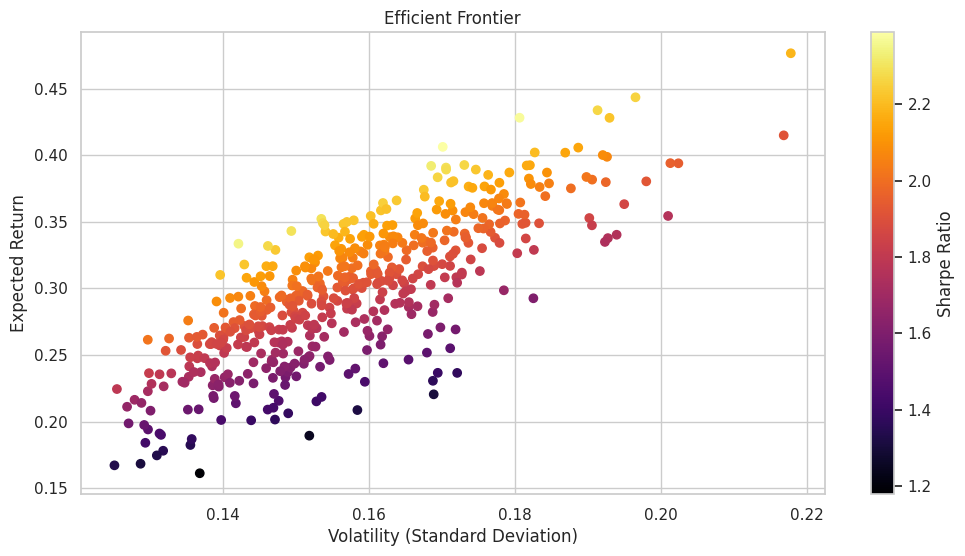

In [10]:
def pf_perf(weights, returns, volatility):
  pr = np.sum(weights * returns)
  pv = np.sqrt(np.dot(weights.T, np.dot(volatility, weights)))
  return pr, pv

num_pf = 500

results = np.zeros((3, num_pf))

vol_matrix = returns.cov()*252
np.random.seed(42)

for i in range(num_pf):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    pr, pv = pf_perf(weights, exp_returns, vol_matrix)
    results[0,i] = pr
    results[1,i] = pv
    results[2,i] = pr/pv

plt.figure(figsize=(12,6))
plt.scatter(results[1,:], results[0,:], c = results[2,:], cmap='inferno', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [11]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.40618726940830846, 0.17006337560939797, 2.3884464715156573)

In [12]:
max_sharpe_weights = np.zeros(len(tickers))

for i in range(num_pf):
  weights = np.random.random(len(tickers))
  weights /= np.sum(weights)

  pr, pv = pf_perf(weights, exp_returns, vol_matrix)

  if results[2,i] == max_sharpe_ratio:
    max_sharpe_weights = weights
    break

pf_weights = pd.DataFrame({
    'Ticker': tickers,
    'Weight': max_sharpe_weights
})

pf_weights


,Ticker,Weight
0,AAPL,0.001199
1,ACN,0.167673
2,AMZN,0.202365
3,BRK-B,0.031310
4,GOOGL,0.021541
5,LLY,0.095142
6,META,0.209228
7,MSFT,0.121543
8,NVDA,0.118198
9,PFE,0.031625
